# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Datos y librerias

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV

In [3]:
# Datos

try:
    df = pd.read_csv('C:/Users/tomas/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
# Aprovechamos a utilizar como índice las fechas

## Conociendo los datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


La media y el promedio están separados por menos de un punto, lo que sugiere que nuestra muestra está cerca del equilibrio. Sin embargo, la presencia de valores extremadamente altos, aunque posiblemente en pequeña cantidad, puede estar afectando esta percepción. Para visualizar mejor la distribución de los datos, utilizaremos un diagrama de caja (boxplot).

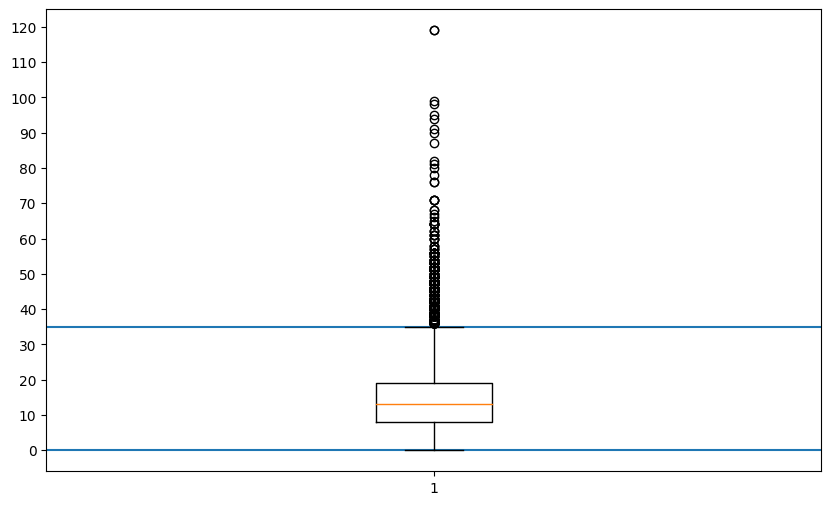

In [8]:
plt.figure(figsize=(10,6))
plt.boxplot(df)
plt.hlines(35, xmin=0.5, xmax=1.5)
plt.hlines(0, xmin=0.5, xmax=1.5)
plt.yticks(np.arange(0, 121, 10))
plt.show()

Como predijimos, tenemos valores elevados que se desvían de la norma. No eliminaremos estos datos, ya que nos indican que el rango típico de viajes está entre 0 y 35 viajes cada 10 minutos. Analizaremos más gráficos para obtener una visión más clara de los datos.

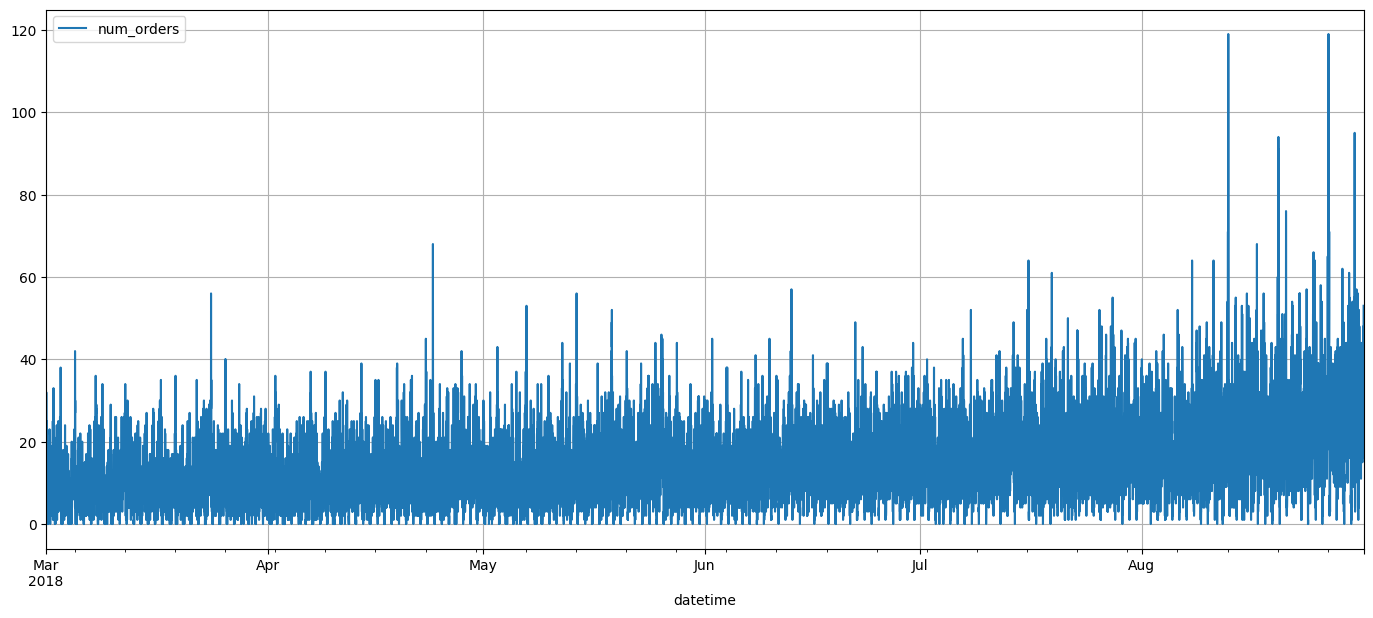

In [9]:
df.plot(figsize=(17,7), grid=True)
plt.show()

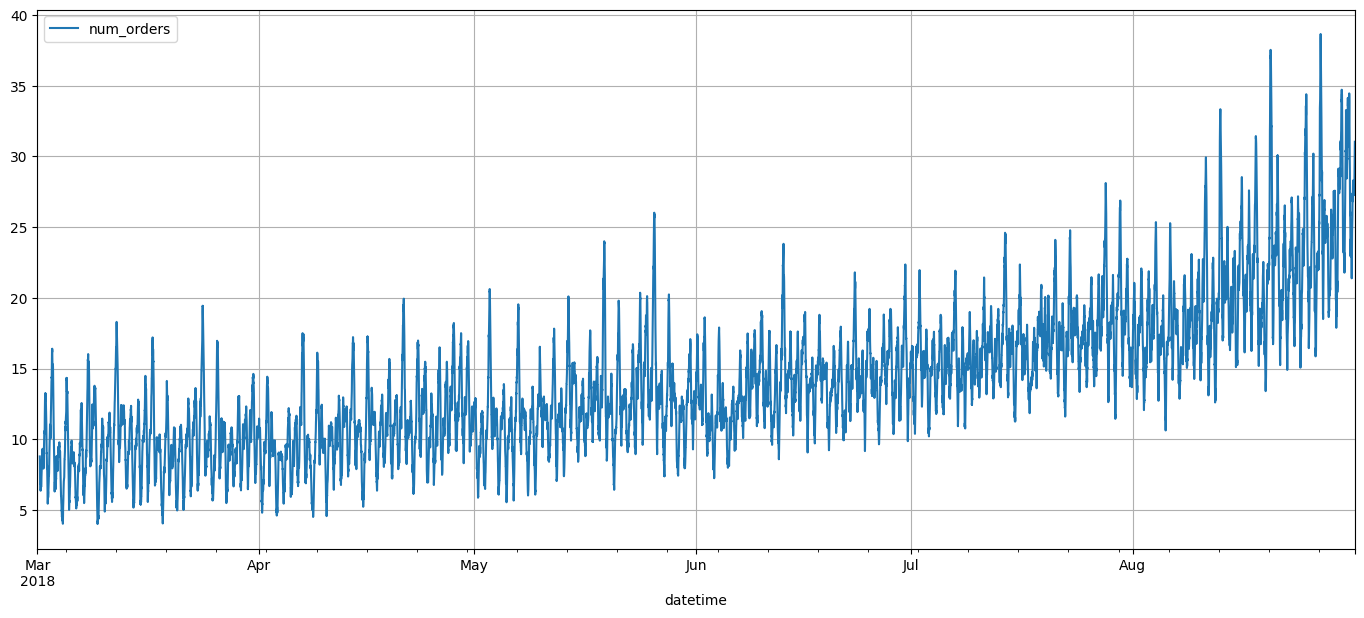

In [10]:
df.rolling(50).mean().plot(figsize=(17,7), grid=True)
plt.show()

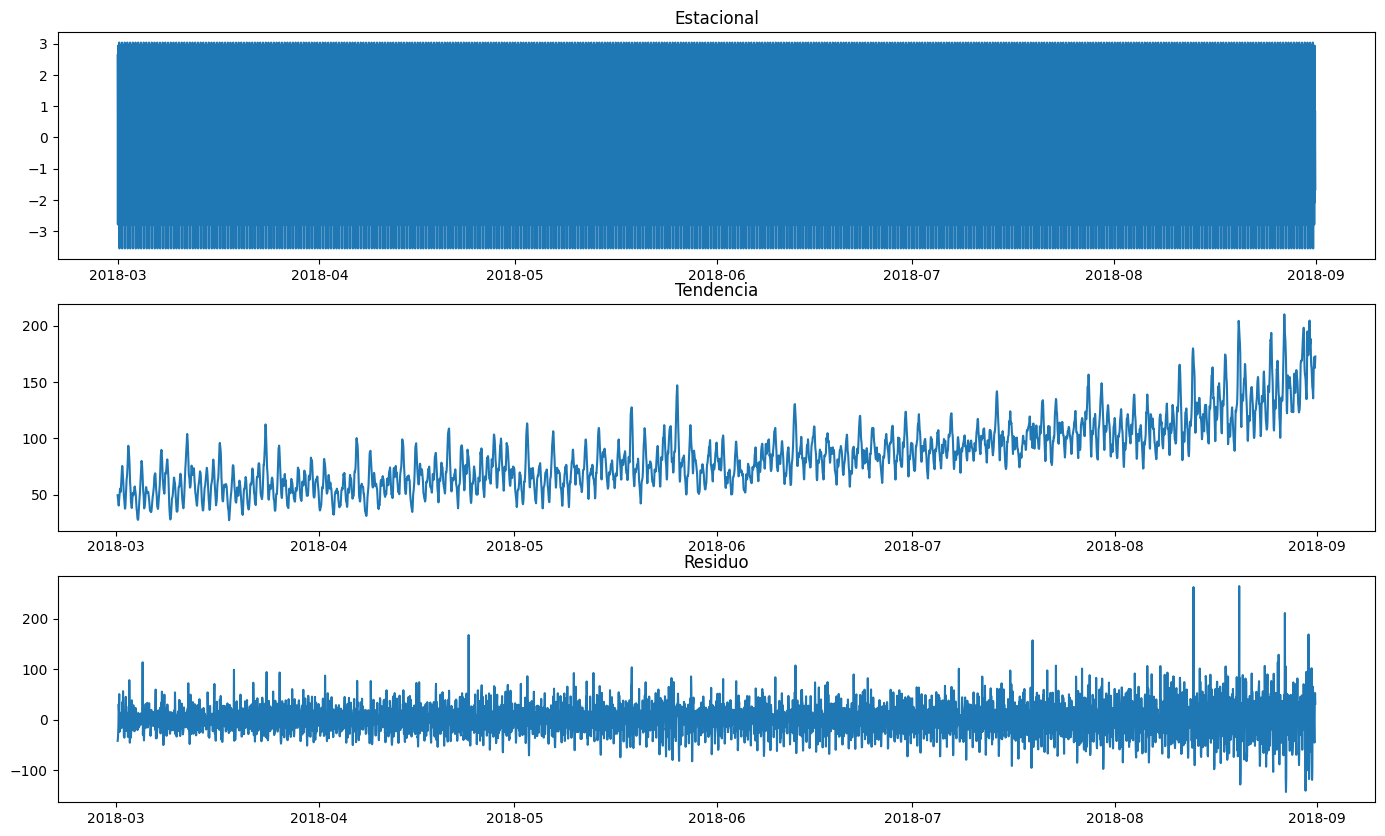

In [11]:
seasonal = seasonal_decompose(df.resample('1H').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

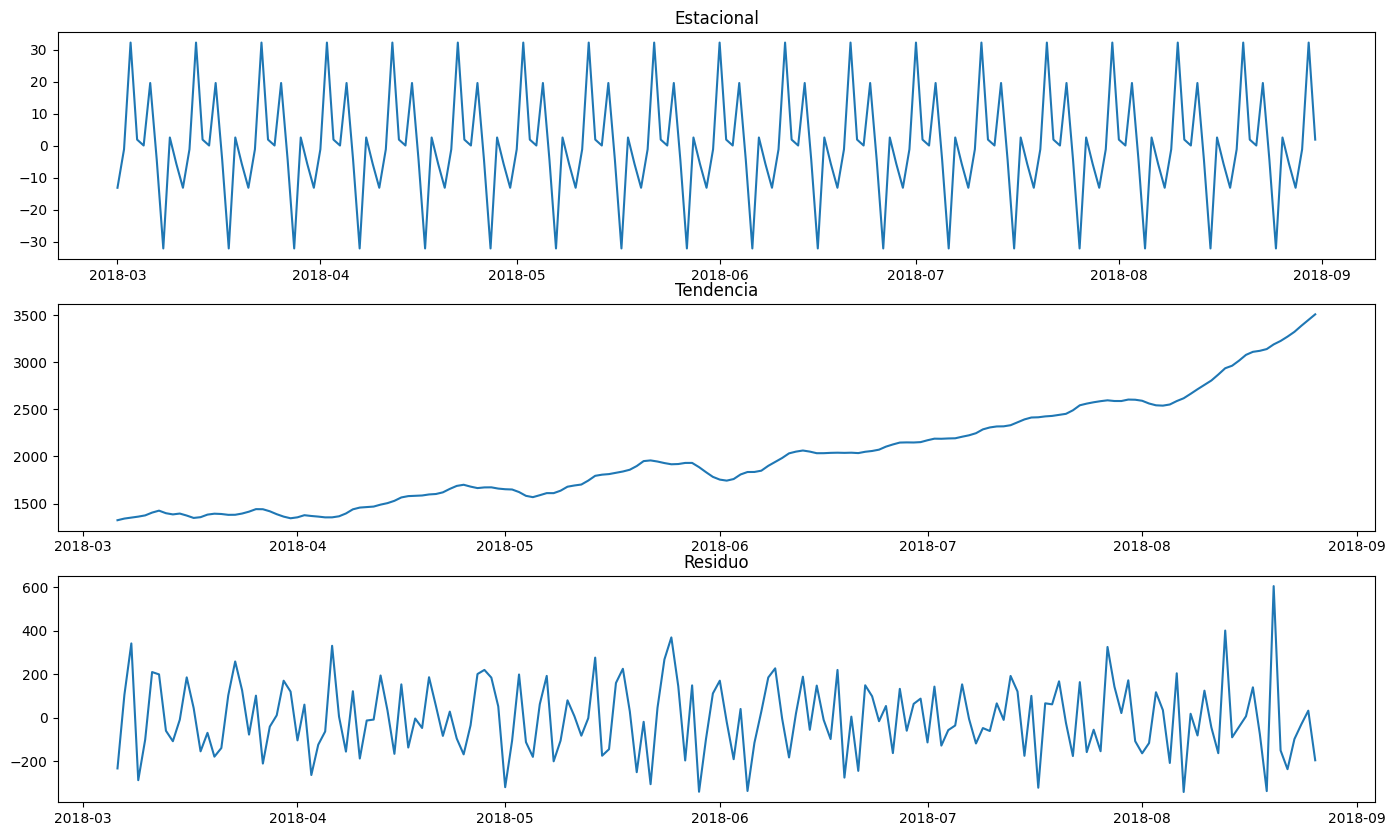

In [12]:
seasonal = seasonal_decompose(df.resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

Podemos observar un componente estacional al analizar los datos por día. Es probable que, a lo largo de una semana, haya días con una alta cantidad de viajes y otros con una baja cantidad de viajes.

## Preparación

Cuando detectamos una tendencia, podemos descomponer los datos hasta alcanzar la estacionariedad. Si enfrentamos problemas de volatilidad, es decir, si la varianza no es constante a lo largo de la serie, podemos aplicar modelos ARCH o GARCH.

Ahora que entendemos los datos con los que trabajaremos, pasemos a crear las características para nuestro modelo. Sin embargo, primero ajustaremos los intervalos de tiempo medidos. Los datos actuales están en intervalos de 10 minutos, pero el proyecto requiere predecir los viajes en la próxima hora. Por lo tanto, cambiaremos los intervalos a una hora para realizar estas predicciones.

In [13]:
df_h = df.resample('1H').sum()

df_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [15]:
df_ft = make_features(df_h, 4, 6)

df_ft.head(10)

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,5,3,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,35.500000


Antes de continuar, eliminemos los valores vacíos que quedaron en nuestros datos.

In [16]:
df_ft.dropna(inplace=True)

df_ft.head()

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,35.500000
2018-03-01 09:00:00,69,9,3,1,3,34.0,15.0,12.0,6.0,29.333333
2018-03-01 10:00:00,64,10,3,1,3,69.0,34.0,15.0,12.0,29.833333


## Features y targets

In [17]:
rs = RandomState(54321) # Fijemos una semilla para estabilidad

Ahora que hemos definido nuestras características y objetivos, dividiremos los datos para entrenar nuestros modelos. Recordemos que debemos reservar un 10% de los datos para el testeo final.

In [18]:
# Separamos los datos de testeo del resto de los datos
rest, test = train_test_split(df_ft, shuffle=False, test_size=0.1)

# Separamos los datos para entrenamiento y validación
train, valid = train_test_split(rest, test_size=0.25, random_state=rs)

# Creamos features y targets para entrenaminto
features_train = train.drop('num_orders', axis=1)
targets_train = train['num_orders']

# Creamos features y targets para testeo
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

# Creamos features y targets para validación
features_valid = valid.drop('num_orders', axis=1)
targets_valid = valid['num_orders']

# Creamos features y targets para el entrenamiento de la validación
features_rest = rest.drop('num_orders', axis=1)
targets_rest = rest['num_orders']

# Comprobemos el tamaño de los sets
print('Entrenamiento:')
print(features_train.shape)
print(targets_train.shape)
print()
print('Validación:')
print(features_valid.shape)
print(targets_valid.shape)
print()
print('Testeo')
print(features_test.shape)
print(targets_test.shape)

Entrenamiento:
(2976, 9)
(2976,)

Validación:
(993, 9)
(993,)

Testeo
(441, 9)
(441,)


## Análisis

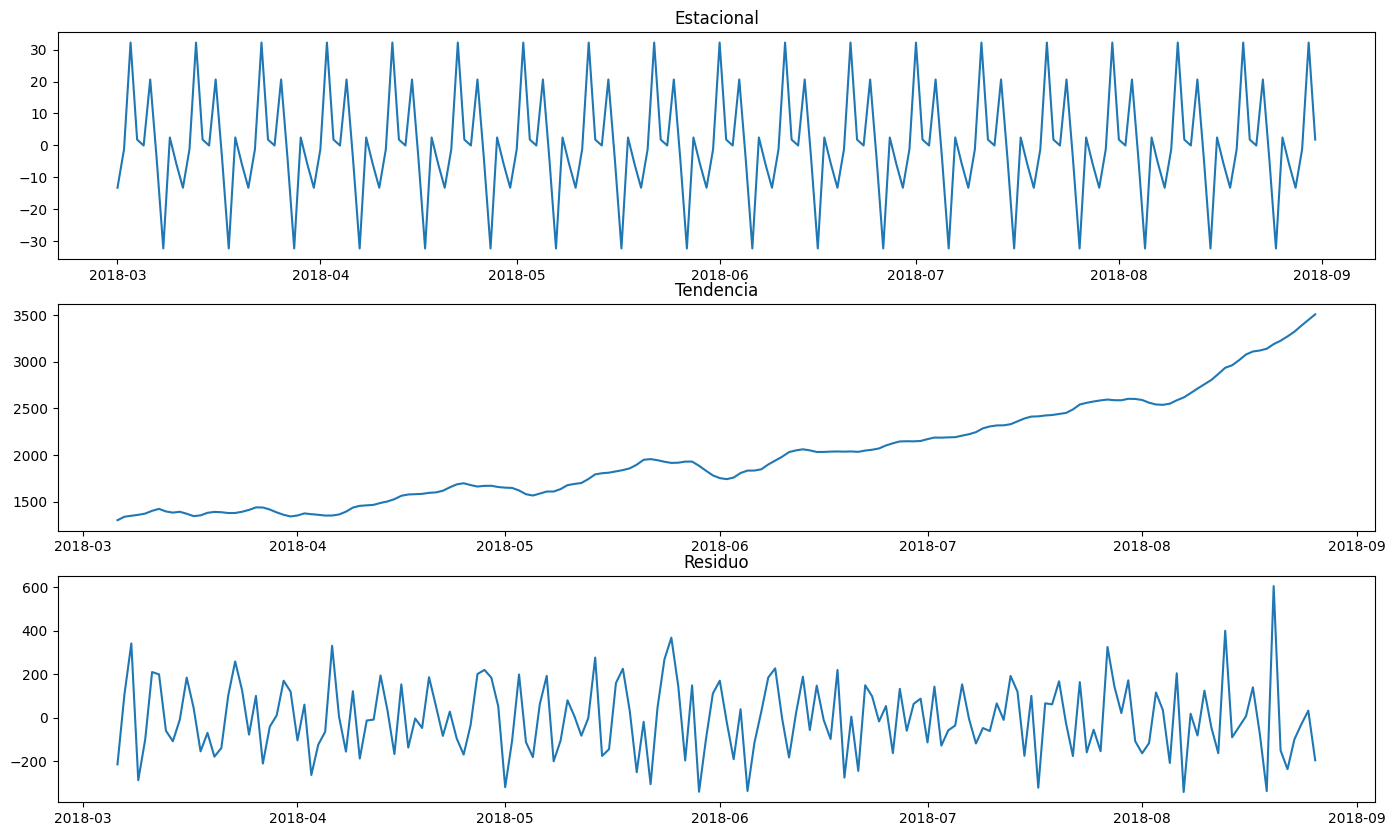

In [19]:
seasonal = seasonal_decompose(df_ft['num_orders'].resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacional')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuo')
plt.show()

Al parecer, el componente estacional ha cambiado debido a las modificaciones que hemos realizado. Ahora presenta valores ligeramente mayores y una forma distinta a la original. Sin embargo, estos cambios no son suficientes para alterar la tendencia de los datos. Al observar las unidades, podemos ver que la estacionalidad no impacta significativamente la cantidad total de viajes. Por otro lado, el residuo se aproxima al 10% de la tendencia, lo cual es considerablemente alto y podría afectar nuestros modelos. Esperamos que afinando los hiperparámetros podamos resolver este problema.

## Formación

En esta sección, compararemos diferentes modelos y buscaremos obtener el menor RMSE posible. Además, debemos asegurarnos de que este valor no supere el umbral de 48.

### Prueba de cordura con regresión lineal

Comencemos con una regresión lineal. Este modelo probablemente nos dé los peores resultados, pero por su rapidez es buena para establecer un punto de partida para los siguientes modelos.

In [20]:
reg = LinearRegression()
reg.fit(features_train, targets_train)
reg_pred = reg.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, reg_pred)**0.5)

RECM:
31.644380412156675


Ya hemos superado la condición para los modelos, tal vez este modelo si sea el indicado para este problema. Veamos los siguientes modelos y luego testearemos al mejor.

### Bosque aleatorio con ajuste de hiperparámetros

In [21]:
score = max(df['num_orders'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs)
        forest.fit(features_train, targets_train)
        f_pred = forest.predict(features_valid)
        sco = mean_squared_error(targets_valid, f_pred)**0.5
        if sco<score:
            score = sco
            best_root = roots
            best_leaf = leafs
            best_pred = f_pred
            best_n = n
        n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)
print('Raices:', best_root)
print('Hojas:', best_leaf)

Mejor ronda: 24
Mejor RECM: 25.916815052763546
Raices: 7
Hojas: 6


Este modelo se toma mucho tiempo en ejecutar, pero podemos ver que el resultado a mejorado. Veamos si podemos seguir mejorando con el resto de los modelos.

### CatBoost

In [22]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
cat_pred = cat.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, cat_pred)**0.5)

RECM:
24.50200199425699


Este modelo es rápido y ofrece mejores resultados. Aunque las mejoras son pequeñas, se acumulan con el tiempo. Lo importante es que hemos superado al modelo anterior. Continuemos con el último modelo antes de decidir el ganador.

### LightGBM

In [23]:
lgbm = lgb.LGBMRegressor(random_state=rs)
lgbm.fit(features_train, targets_train,eval_metric = 'RMSE', eval_set=(features_valid, targets_valid))
lgbm_pred = lgbm.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, lgbm_pred)**0.5)

[1]	valid_0's rmse: 38.0601	valid_0's l2: 1448.57
[2]	valid_0's rmse: 36.271	valid_0's l2: 1315.59
[3]	valid_0's rmse: 34.8484	valid_0's l2: 1214.41
[4]	valid_0's rmse: 33.6133	valid_0's l2: 1129.85
[5]	valid_0's rmse: 32.4241	valid_0's l2: 1051.32
[6]	valid_0's rmse: 31.5128	valid_0's l2: 993.057
[7]	valid_0's rmse: 30.5293	valid_0's l2: 932.036
[8]	valid_0's rmse: 29.7774	valid_0's l2: 886.695
[9]	valid_0's rmse: 29.1271	valid_0's l2: 848.39
[10]	valid_0's rmse: 28.6212	valid_0's l2: 819.173
[11]	valid_0's rmse: 28.141	valid_0's l2: 791.915
[12]	valid_0's rmse: 27.7944	valid_0's l2: 772.531
[13]	valid_0's rmse: 27.5102	valid_0's l2: 756.809
[14]	valid_0's rmse: 27.1884	valid_0's l2: 739.208
[15]	valid_0's rmse: 26.8922	valid_0's l2: 723.192
[16]	valid_0's rmse: 26.4948	valid_0's l2: 701.973
[17]	valid_0's rmse: 26.2352	valid_0's l2: 688.284
[18]	valid_0's rmse: 26.02	valid_0's l2: 677.038
[19]	valid_0's rmse: 25.832	valid_0's l2: 667.292
[20]	valid_0's rmse: 25.6968	valid_0's l2: 660

Por esta vez, tendremos que descartar a este modelo, pues no ha logrado superar a CatBoost, aunque ha estado muy cerca. Pasemos al testeo del mejor modelo.

## Prueba

In [24]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_rest, targets_rest, eval_set=(features_test, targets_test))
cat_pred = cat.predict(features_test)
print('RECM:')
print(mean_squared_error(targets_test, cat_pred)**0.5)

RECM:
44.68549340766175


Al parecer, entrenar nuestro último modelo con una mayor cantidad de información no mejoró los resultados. El valor del RMSE ha aumentado a casi 44.6, aunque todavía estamos por debajo del máximo permitido. Podemos afirmar con certeza que el modelo CatBoost es el mejor para predecir la cantidad de viajes en la próxima hora. Sin embargo, realizaremos otra ejecución de CatBoost con ajustes en los hiperparámetros.

In [25]:
score = max(df['num_orders'])
for metric in ['MAE', 'MAPE', 'Poisson', 'RMSE']:
    for roots in range(3,8):
        for leafs in range(3,8):
            cat2 = CatBoostRegressor(iterations=200, silent=True, l2_leaf_reg=leafs, depth=roots, loss_function=metric)
            cat2.fit(features_rest, targets_rest, eval_set=(features_test, targets_test))
            cat_pred = cat2.predict(features_test)
            sco = mean_squared_error(targets_test, cat_pred)**0.5
            if sco<score:
                score = sco
                best_root = roots
                best_leaf = leafs
                best_metric = metric
                best_pred = sco

print('RECM:', best_pred)
print('Depth:', best_root)
print('Leafs:', best_leaf)
print('Metric:', best_metric)

RECM: 48.693744393071
Depth: 6
Leafs: 3
Metric: RMSE


El valor de RECM ha aumentado por sobre la máxima. Al parecer los hiperparámetros automáticos son mejores para nuestro modelo. Nos quedamos con la versión estándar del modelo CatBoost.

In [28]:
score = max(df['num_orders'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        for metric in ['mse', 'mae', 'poisson']:
            forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs, criterion=metric)
            forest.fit(features_rest, targets_rest)
            f_pred = forest.predict(features_test)
            sco = mean_squared_error(targets_test, f_pred)**0.5
            if sco<score:
                score = sco
                best_root = roots
                best_leaf = leafs
                best_pred = f_pred
                best_n = n
                best_metric = metric
            n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)
print('Raices:', best_root)
print('Hojas:', best_leaf)
print('Metrica:', best_metric)

Mejor ronda: 64
Mejor RECM: 50.5125653815415
Raices: 7
Hojas: 4
Metrica: mse
